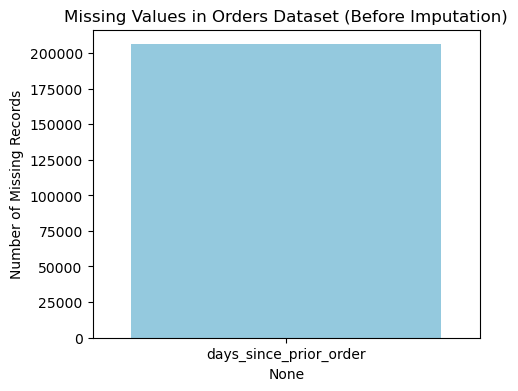

 206209 missing data .
we will fill the missing data with a (0).
current memory usage : 2227.10 MB


In [5]:

import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
# 1. reading only important cols 
o = pd.read_csv("orders.csv", usecols=['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])
opp = pd.read_csv("order_products__prior.csv", usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])


import seaborn as sns

# 1.reading o again for detecting missing data 
orders_raw = pd.read_csv("orders.csv")

# where is the missing data 
missing_stats = orders_raw.isnull().sum()
missing_stats = missing_stats[missing_stats > 0]

# visulization of cols that has missing data 
if not missing_stats.empty:
    plt.figure(figsize=(5, 4))
    sns.barplot(x=missing_stats.index, y=missing_stats.values, color='skyblue')
    plt.title('Missing Values in Orders Dataset (Before Imputation)')
    plt.ylabel('Number of Missing Records')
    plt.show()
    
   
    print(f" {missing_stats['days_since_prior_order']} missing data .")
    print("we will fill the missing data with a (0).")

del orders_raw 

# sol for missing data 
o['days_since_prior_order'] = o['days_since_prior_order'].fillna(0)


# merging 
full = opp.merge(o, on="order_id", how="left")

# deleting not important cols 
del o, opp
gc.collect()

print(f"current memory usage : {full.memory_usage().sum() / 1024**2:.2f} MB")



In [7]:
# memory opt
def auto_downcast(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df


full = auto_downcast(full)
gc.collect()

print(f" full after memory opt : {full.memory_usage().sum() / 1024**2:.2f} MB")

 full after memory opt : 680.50 MB


In [9]:

if 'order_id' in full.columns:
    full = full.drop(columns=['order_id'])


gc.collect()

print(f" memory after droping order_id : {full.memory_usage().sum() / 1024**2:.2f} MB")

 memory after droping order_id : 556.78 MB


In [11]:

full['days_since_prior_order'] = full['days_since_prior_order'].astype(np.int8)

gc.collect()
print(f"final memory usage : {full.memory_usage().sum() / 1024**2:.2f} MB")

final memory usage : 463.98 MB


In [13]:
full.head()

,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,33120,1,1,202279,3,5,9,8
1,28985,2,1,202279,3,5,9,8
2,9327,3,0,202279,3,5,9,8
3,45918,4,1,202279,3,5,9,8
4,30035,5,0,202279,3,5,9,8


In [17]:
# detecting missing data on full 
missing_data = full.isnull().sum().to_frame('missing_count')


print(missing_data)

# vis for cols that has missing data 
if missing_data['missing_count'].sum() > 0:
    missing_data['missing_count'].plot(kind='bar', color='salmon')
    plt.title('Missing Values per Column')
    plt.show()
else:
    print("\n no missing data on full  ")

                        missing_count
product_id                          0
add_to_cart_order                   0
reordered                           0
user_id                             0
order_number                        0
order_dow                           0
order_hour_of_day                   0
days_since_prior_order              0

 no missing data on full  


Missing Value Table:
                        count
product_id                  0
add_to_cart_order           0
reordered                   0
user_id                     0
order_number                0
order_dow                   0
order_hour_of_day           0
days_since_prior_order      0


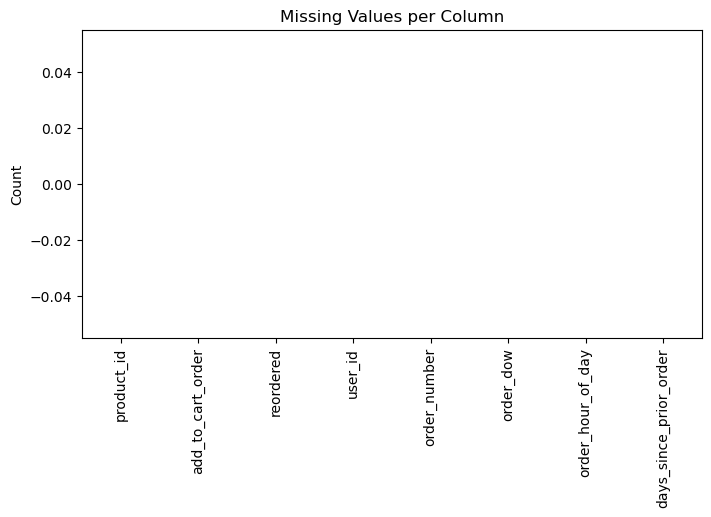

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


missing = full.isnull().sum().to_frame('count')


print("Missing Value Table:")
print(missing)
# proof that there is no missing data 
plt.figure(figsize=(8, 4))
missing['count'].plot(kind='bar', color='skyblue')
plt.title('Missing Values per Column')
plt.ylabel('Count')
plt.show()

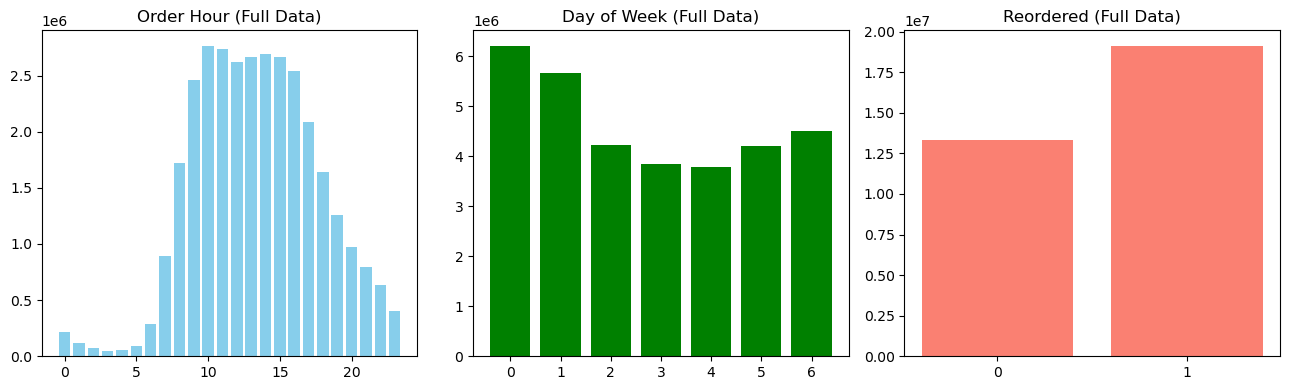

In [21]:

# used np bc its faster than pd 
hour_values, hour_counts = np.unique(full['order_hour_of_day'].values, return_counts=True)
dow_values, dow_counts = np.unique(full['order_dow'].values, return_counts=True)
reorder_values, reorder_counts = np.unique(full['reordered'].values, return_counts=True)

# vis of the frequancy
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

axes[0].bar(hour_values, hour_counts, color='skyblue')
axes[0].set_title('Order Hour (Full Data)')

axes[1].bar(dow_values, dow_counts, color='green')
axes[1].set_title('Day of Week (Full Data)')

axes[2].bar(reorder_values, reorder_counts, color='salmon')
axes[2].set_title('Reordered (Full Data)')
axes[2].set_xticks([0, 1])

plt.tight_layout()
plt.show()

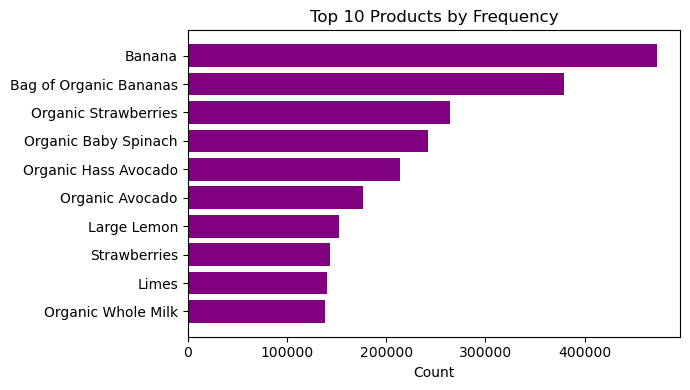

In [25]:
# top 10 products 
p_ids, p_counts = np.unique(full['product_id'].values, return_counts=True)
top_indices = np.argsort(p_counts)[-10:][::-1] 

top_p_ids = p_ids[top_indices]
top_p_counts = p_counts[top_indices]

# names not index 
names_df = pd.read_csv("products.csv", usecols=['product_id', 'product_name'])
top_names = [names_df[names_df['product_id']==pid]['product_name'].values[0] for pid in top_p_ids]


plt.figure(figsize=(7, 4))
plt.barh(top_names[::-1], top_p_counts[::-1], color='purple')
plt.title('Top 10 Products by Frequency')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

del names_df

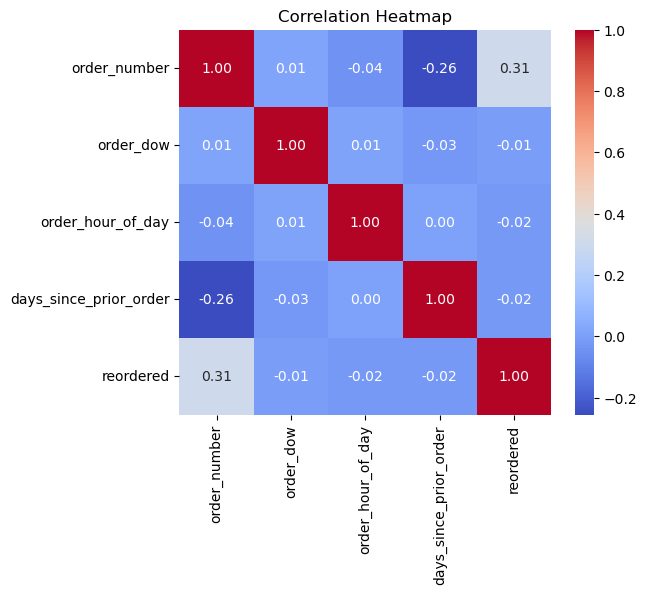

In [10]:
plt.figure(figsize=(6, 5))
# sample bc its faster 
cols = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered']
sns.heatmap(full[cols].sample(100000).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

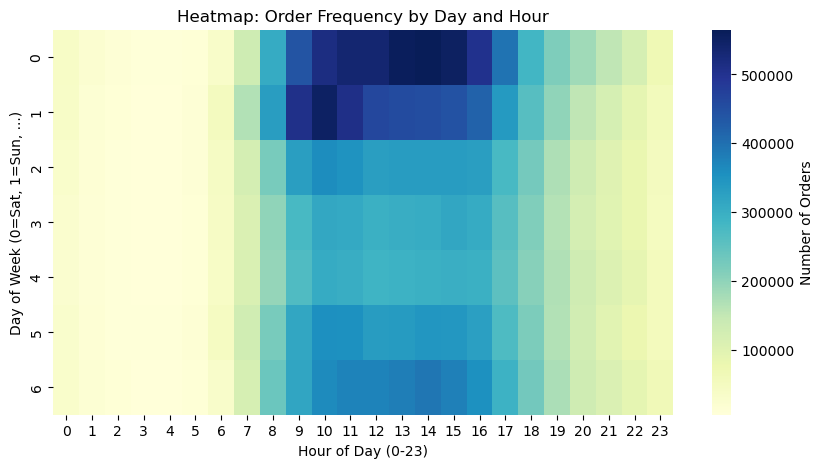

13537

In [27]:
#  (Seasonality: Day vs Hour)
# orders per hour 
seasonality_table = full.groupby(['order_dow', 'order_hour_of_day']).size().unstack()

#(Heatmap)
plt.figure(figsize=(10, 5))
sns.heatmap(seasonality_table, cmap='YlGnBu', cbar_kws={'label': 'Number of Orders'})

plt.title('Heatmap: Order Frequency by Day and Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Day of Week (0=Sat, 1=Sun, ...)')
plt.show()


import gc
del seasonality_table
gc.collect()

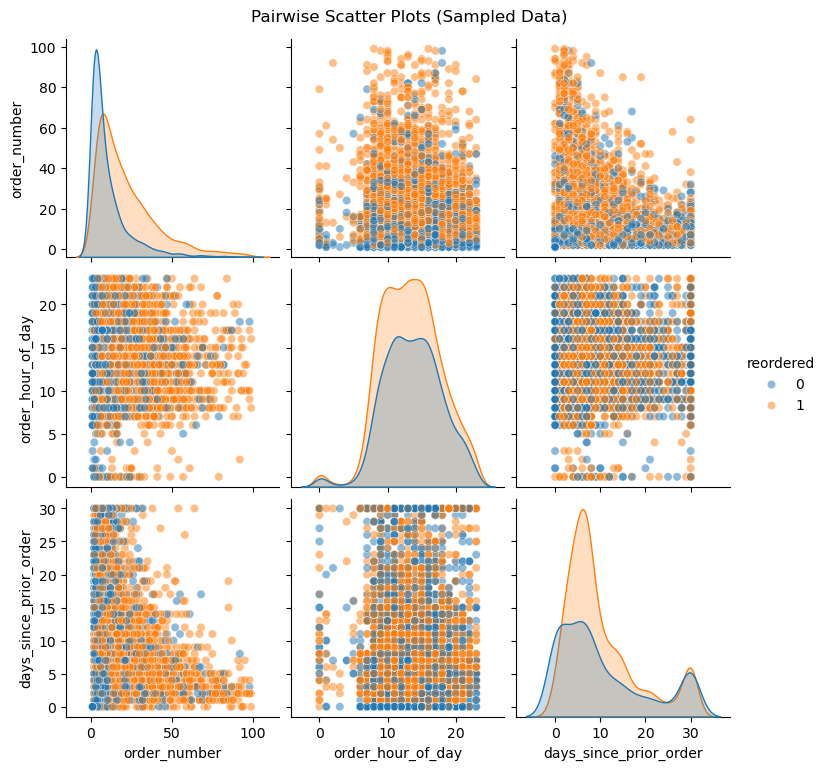

In [12]:

selected_features = ['order_number', 'order_hour_of_day', 'days_since_prior_order', 'reordered']


sample_for_plot = full[selected_features].sample(5000, random_state=42)


sns.pairplot(sample_for_plot, hue='reordered', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Scatter Plots (Sampled Data)', y=1.02)
plt.show()


del sample_for_plot

In [13]:

#  Winsorizing

q_limit = full['days_since_prior_order'].quantile(0.95)
full['days_since_prior_order'] = full['days_since_prior_order'].clip(upper=q_limit)


order_limit = full['order_number'].quantile(0.95)
full['order_number'] = full['order_number'].clip(upper=order_limit)

print(f"Done! Outliers capped at: {q_limit} days and {order_limit} orders.")

Done! Outliers capped at: 30.0 days and 54.0 orders.


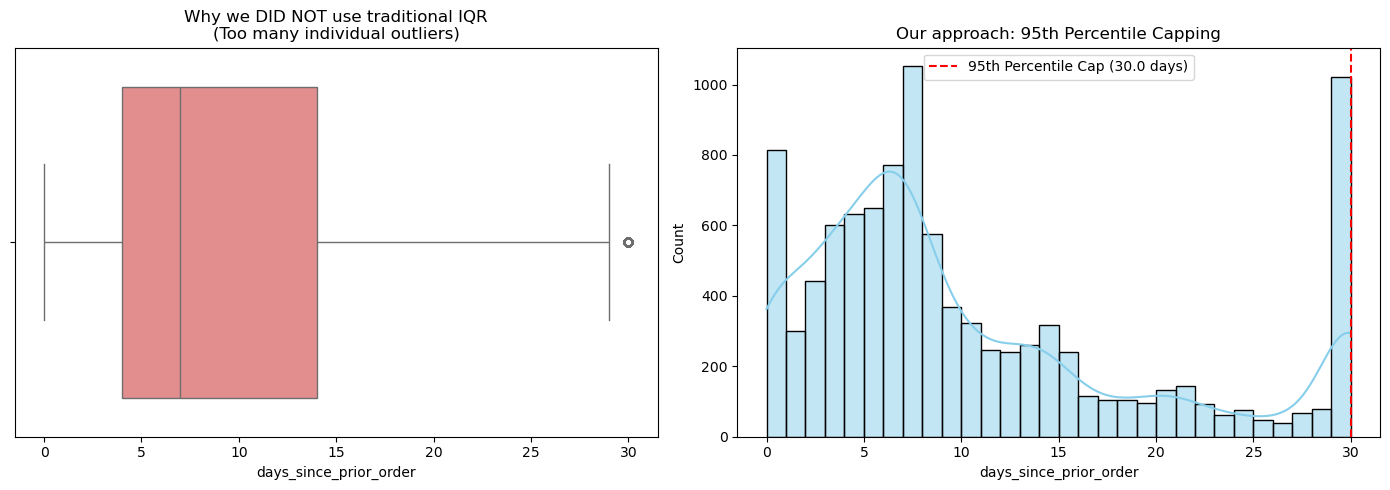

Starting Outlier treatment...
Outliers are now capped: Days at 30.0, Orders at 54.0


38430

In [14]:


# proof
sample_plot = full['days_since_prior_order'].sample(10000)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
sns.boxplot(x=sample_plot, color='lightcoral')
plt.title('Why we DID NOT use traditional IQR\n(Too many individual outliers)')


plt.subplot(1, 2, 2)
sns.histplot(sample_plot, bins=30, kde=True, color='skyblue')

cap_value = full['days_since_prior_order'].quantile(0.95)
plt.axvline(cap_value, color='red', linestyle='--', label=f'95th Percentile Cap ({cap_value} days)')
plt.title('Our approach: 95th Percentile Capping')
plt.legend()

plt.tight_layout()
plt.show()


del sample_plot
gc.collect()



print(f"Starting Outlier treatment...")


days_cap = full['days_since_prior_order'].quantile(0.95)
full['days_since_prior_order'] = full['days_since_prior_order'].clip(upper=days_cap)


order_cap = full['order_number'].quantile(0.95)
full['order_number'] = full['order_number'].clip(upper=order_cap)

print(f"Outliers are now capped: Days at {days_cap}, Orders at {order_cap}")


gc.collect()

In [29]:

from sklearn.model_selection import KFold

# One-Hot Encoding 
full = pd.get_dummies(full, columns=['order_dow'], prefix='day', drop_first=True)


# Frequency Encoding 

hour_freq = full['order_hour_of_day'].value_counts(normalize=True)
full['hour_freq'] = full['order_hour_of_day'].map(hour_freq)


# Target Encoding 

def smooth_target_encode(df, column, target, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    new_column = column + '_target_enc'
    df[new_column] = np.nan
    
    global_mean = df[target].mean() 
    for train_idx, val_idx in kf.split(df):
        
        ordered_stats = df.iloc[train_idx].groupby(column)[target].mean()
        df.loc[df.index[val_idx], new_column] = df.loc[df.index[val_idx], column].map(ordered_stats)
        
   
    df[new_column] = df[new_column].fillna(global_mean)
    return df


full = smooth_target_encode(full, 'product_id', 'reordered')

print("Encoding Finished Successfully!")

Encoding Finished Successfully!


In [35]:

user_last_order = full.groupby('user_id')['order_number'].transform('max')


past_orders = full[full['order_number'] < user_last_order]

current_order = full[full['order_number'] == user_last_order].copy()


user_stats = past_orders.groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_avg_days_between=('days_since_prior_order', 'mean')
).reset_index()


product_stats = past_orders.groupby('product_id').agg(
    prod_avg_cart_pos=('add_to_cart_order', 'mean'),
    prod_total_purchases=('product_id', 'count')
).reset_index()


uxp_stats = past_orders.groupby(['user_id', 'product_id']).size().reset_index(name='user_product_count')


full_cleaned = current_order.merge(user_stats, on='user_id', how='left')
full_cleaned = full_cleaned.merge(product_stats, on='product_id', how='left')
full_cleaned = full_cleaned.merge(uxp_stats, on=['user_id', 'product_id'], how='left')


full_cleaned.fillna(0, inplace=True)


full_cleaned = full_cleaned.drop_duplicates(subset=['user_id', 'product_id'])


del past_orders, current_order, user_stats, product_stats, uxp_stats
gc.collect()

print(f" full cleaned shape {full_cleaned.shape}")
print(f" full_cleaned  : {full_cleaned.columns.tolist()}")

 full cleaned shape (2139788, 20)
 full_cleaned  : ['product_id', 'add_to_cart_order', 'reordered', 'user_id', 'order_number', 'order_hour_of_day', 'days_since_prior_order', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_freq', 'product_id_target_enc', 'user_total_orders', 'user_avg_days_between', 'prod_avg_cart_pos', 'prod_total_purchases', 'user_product_count']


In [36]:


# extra code bc we had the leakage problem on the previous code 
print("🔍 1. فحص الارتباط بين الميزات والهدف (Reordered):")

features_to_check = [
    'user_total_orders', 'user_avg_days_between', 
    'prod_avg_cart_pos', 'prod_total_purchases', 'user_product_count',
    'order_hour_of_day', 'days_since_prior_order', 'reordered'
]

corr_matrix = full_cleaned[features_to_check].corr()
reorder_corr = corr_matrix['reordered'].sort_values(ascending=False)
print(reorder_corr)
print("\n💡 ملاحظة: إذا وجدتِ أي ميزة ارتباطها > 0.8 فهناك تسريب (Leakage).")
print("-" * 30)


print("🔍 2. فحص الأسطر المكررة:")
dup_count = full_cleaned.duplicated(subset=['user_id', 'product_id']).sum()
print(f"عدد الثنائيات (مستخدم-منتج) المكررة: {dup_count}")
print("-" * 30)


print("🔍 3. توزيع الفئات في الطلب الأخير:")
print(full_cleaned['reordered'].value_counts(normalize=True) * 100)
print("-" * 30)


print("🔍 4. نظرة على القيم (Stats Summary):")
print(full_cleaned[features_to_check].describe().loc[['mean', 'min', 'max']])

🔍 1. فحص الارتباط بين الميزات والهدف (Reordered):
reordered                 1.000000
user_product_count        0.454365
prod_total_purchases      0.151346
user_total_orders         0.146176
order_hour_of_day        -0.016008
user_avg_days_between    -0.052225
days_since_prior_order   -0.114071
prod_avg_cart_pos        -0.180480
Name: reordered, dtype: float64

💡 ملاحظة: إذا وجدتِ أي ميزة ارتباطها > 0.8 فهناك تسريب (Leakage).
------------------------------
🔍 2. فحص الأسطر المكررة:
عدد الثنائيات (مستخدم-منتج) المكررة: 0
------------------------------
🔍 3. توزيع الفئات في الطلب الأخير:
reordered
1    58.77085
0    41.22915
Name: proportion, dtype: float64
------------------------------
🔍 4. نظرة على القيم (Stats Summary):
      user_total_orders  user_avg_days_between  prod_avg_cart_pos  \
mean          22.160832              10.663736           8.470989   
min            2.000000               0.000000           0.000000   
max           53.000000              29.732143          50.00000

In [45]:
from sklearn.preprocessing import StandardScaler



features_to_scale = [
    'user_total_orders', 'user_avg_days_between', 
    'prod_avg_cart_pos', 'prod_total_purchases', 'user_product_count',
    'order_hour_of_day', 'days_since_prior_order', 'hour_freq'
]


scaler = StandardScaler()

full_cleaned[features_to_scale] = scaler.fit_transform(full_cleaned[features_to_scale])

print("scaled done ")


print(full_cleaned[features_to_scale].describe().loc[['mean', 'std', 'min', 'max']])

scaled done 
      user_total_orders  user_avg_days_between  prod_avg_cart_pos  \
mean       1.291058e-17           2.507096e-15      -1.483103e-15   
std        1.000000e+00           1.000000e+00       1.000000e+00   
min       -7.870902e-01          -2.191182e+00      -5.003896e+00   
max        4.981793e+00           3.140684e+00       2.495064e+01   

      prod_total_purchases  user_product_count  order_hour_of_day  \
mean         -1.999347e-17       -4.167381e-17      -1.663034e-16   
std           1.000000e+00        1.000000e+00       1.000000e+00   
min          -4.395793e-01       -5.145545e-01      -3.198378e+00   
max           5.632111e+00        1.674250e+01       2.233125e+00   

      days_since_prior_order     hour_freq  
mean           -1.777197e-16  2.796595e-15  
std             1.000000e+00  1.000000e+00  
min            -1.590040e+00 -2.900149e+00  
max             1.360454e+00  8.008453e-01  


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features = [
    'user_total_orders', 'user_avg_days_between', 
    'prod_avg_cart_pos', 'prod_total_purchases', 'user_product_count',
    'order_hour_of_day', 'days_since_prior_order', 'hour_freq'
]

X_vif = full_cleaned[features]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]


print(vif_data.sort_values(by="VIF", ascending=False))

                  feature       VIF
0       user_total_orders  1.617082
4      user_product_count  1.443928
6  days_since_prior_order  1.249947
1   user_avg_days_between  1.231754
2       prod_avg_cart_pos  1.214784
3    prod_total_purchases  1.186439
5       order_hour_of_day  1.049525
7               hour_freq  1.048027


In [55]:



final_file_name = 'instacart_final_scaled_v2.parquet'

print(f" ({len(full_cleaned)} lines )...")
full_cleaned.to_parquet(final_file_name, index=False, compression='snappy')

print(f"saved : {final_file_name}")


 (2139788 lines )...
saved : instacart_final_scaled_v2.parquet


In [ ]:
#The sec way of feauture eng to solve the data leakage 

"""from sklearn.preprocessing import StandardScaler


orders = pd.read_csv('orders.csv') 
user_last_order = full.groupby('user_id')['order_number'].transform('max')
past_orders = full[full['order_number'] < user_last_order]


user_stats = past_orders.groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_avg_days_between=('days_since_prior_order', 'mean')
).reset_index()

product_stats = past_orders.groupby('product_id').agg(
    prod_avg_cart_pos=('add_to_cart_order', 'mean'),
    prod_total_purchases=('product_id', 'count')
).reset_index()

uxp_stats = past_orders.groupby(['user_id', 'product_id']).size().reset_index(name='user_product_count')


features_to_scale = ['user_total_orders', 'user_avg_days_between', 'prod_avg_cart_pos', 'prod_total_purchases', 'user_product_count']
scaler = StandardScaler()
features_df = uxp_stats.merge(user_stats, on='user_id').merge(product_stats, on='product_id')
features_df[features_to_scale] = scaler.fit_transform(features_df[features_to_scale])


train_df = pd.read_csv('order_products__train.csv')

train_df = train_df.merge(orders[['order_id', 'user_id']], on='order_id', how='left')


final_dataset = train_df.merge(features_df, on=['user_id', 'product_id'], how='left')


final_dataset.fillna(0, inplace=True)
final_dataset['reordered'] = (final_dataset['reordered'] > 0).astype(int)
final_dataset.to_parquet('instacart_final_fixed.parquet')


gc.collect()"""